## This notebook demonstrates how to run MassWastingRunout on a real hillslope:
## The Cascade, 2022 landslide

In [1]:
# setup
import os

## import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## import necessary landlab components
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator
from landlab.components import(FlowDirectorD8, 
                                FlowDirectorDINF, 
                                FlowDirectorMFD, 
                                FlowDirectorSteepest)

from landlab.components.mass_wasting_router import MassWastingRunout

## import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from landlab import imshow_grid_at_node

## import functions
from landlab.io.esri_ascii import write_esri_ascii
from landlab.io import read_esri_ascii
from landlab.io.netcdf import read_netcdf

from landlab.components import ChannelProfiler, FlowAccumulator, DepressionFinderAndRouter

# load plotting functions
os.chdir('C:/Users/keckje/Documents/GitHub/landlab/notebooks/tutorials/landslides')
python_file = open("imshow_grid_at_node_with_alpha.txt").read()
exec(python_file)

### set MassWastingRunout parameters

In [2]:
# model run options
mw_id = 1
deposition_rule = "critical_slope"
effective_qsi = True
g_erosion = True
settle_deposit = False
attributes = ['particle__diameter']

# parameters
mw_dict = {'critical slope': [0.15589918235700001],
 'minimum flux': 0.3,
 'scour coefficient': 0.0337443,
 'scour exponent': 0.2,
 'effective particle diameter': 0.316,
 'vol solids concentration': 0.6,
 'density solids': 2650,
 'typical flow thickness, scour': 2,
 'typical slope, scour': 0.25,
 'max observed flow depth': 5,
 'threshold flux': 0.76600115989200002}

### define elevation range over which modeled flow will be compared to observed to evaluate calibration

In [3]:
el_l = 230
el_h = 430

### prep model GIS inputs

In [4]:
# GIS generated inputs
bdfdem = '2019li_5m10m_xv2.asc' # before debris flow dem
lsnodes = 'ls_poly_v5_10m.asc' # landslide poligon nodes
bdfdem_hs = '2019li_2m_xv2_hs.asc' # before debris flow dem hs
odfdem = 'dif_10m_t7.asc' # observed dem difference


### load GIS inputs onto the grid, including the landslide polygon

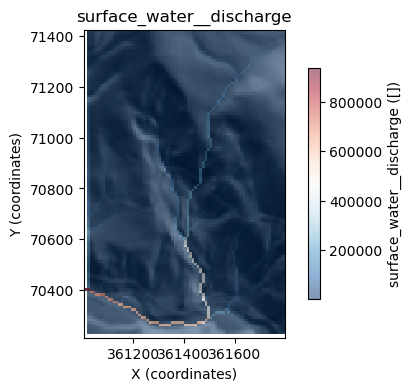

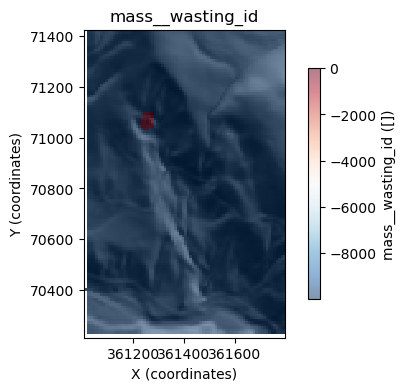

<Figure size 640x480 with 0 Axes>

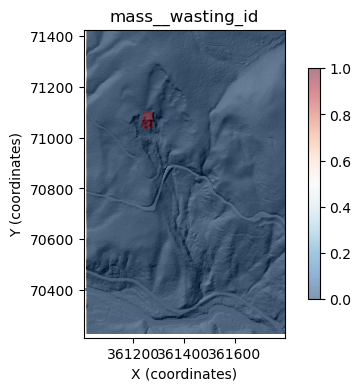

In [5]:
#%% load GIS inputs

# dem
mg, z = read_esri_ascii(bdfdem, name='topographic__elevation')

# ls nodes
_, mw1 = read_esri_ascii(lsnodes, name='mass__wasting_id')
mg.add_field('node', 'mass__wasting_id',mw1.astype(int))

# observed deposition
_, mw1 = read_esri_ascii(odfdem, name='dem_dif_o')
mg.add_field('node', 'dem_dif_o',mw1)
mg.at_node['dem_dif_o'][mg.at_node['dem_dif_o'] == -9999] = 0 # change null values to zero

# soil depth
# here using uniform depth
depth = np.ones(mg.at_node['topographic__elevation'].shape[0])*1.2
mg.add_field('node', 'soil__thickness',depth)

# for landslide, set depth equal to field estimated average depth
lsdepth = 'sd_s1000_v5_10m.asc' # dem difference inferred landslide depth, may need to increase depth at lower part of landslide
_, lsd = read_esri_ascii(lsdepth, name='ls_depth')
lsd = lsd[lsd != -9999]
mg.at_node['soil__thickness'][mg.at_node['mass__wasting_id'] == mw_id] = -1*lsd

# high res hillshade for plot background
mg_hs, hs = read_esri_ascii(bdfdem_hs, name='hillshade')
mg_hs.at_node['hillshade_arc'] = hs
mg_hs.at_node['hillshade_arc'][mg_hs.at_node['hillshade_arc'] == -9999] = np.nan

mg.set_watershed_boundary_condition(z) # finds lowest point in dem and sets it as an open node

# add particle diameter
mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*mw_dict['effective particle diameter']

# flow accumulater to get contributing area to each grid cell
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()

# fill depressions to correct surface area determination
df_4 = DepressionFinderAndRouter(mg)
df_4.map_depressions()

# landlab built in hillshade
mg.at_node['hillshade'] = mg.calc_hillshade_at_node(elevs=z, alt=37., az=210.)
        
# visually check inputs
plot_node_field_with_shaded_dem(mg, field = 'surface_water__discharge', fontsize = 10,cmap = 'RdBu_r',alpha = .5, figsize = (6,4))
plot_node_field_with_shaded_dem(mg, field = 'mass__wasting_id', fontsize = 10,cmap = 'RdBu_r',alpha = .5, figsize = (6,4))
plt.figure()
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'mass__wasting_id',
                                         plot_name = 'high_res', fontsize = 10,cmap = 'RdBu_r',alpha = .5, 
                                         figsize = (6,4), cbr = [0,1])

# save an copy of the initial elevation for dem differencing
_ = mg.add_field('topographic__initial_elevation',
                    mg.at_node['topographic__elevation'],
                    at='node',
                    copy = True)

# multiflow direction for MWRu
# need to delete d8 flow direction
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')

# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'slope')
fd.run_one_step()

### view the landslide polygon before releasing the landslide

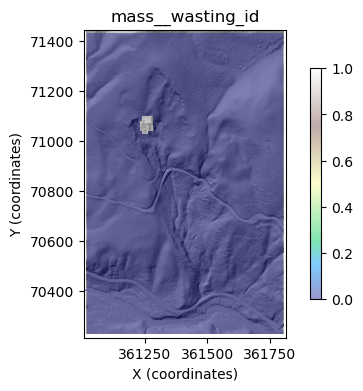

In [6]:
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'mass__wasting_id',plot_name = 'high_res', 
                                         fontsize = 10,alpha = .5, domain_buffer = 20, cbr = [0,1], figsize = (6,4))

### instantiate MassWastingRunout and run it!!!!

In [7]:
#%% set model parameters
MWR = MassWastingRunout(mg,
                                mw_dict, 
                                tracked_attributes = attributes,
                                grain_shear = True,
                                effective_qsi = effective_qsi,
                                settle_deposit = settle_deposit,
                                E_constraint = True,
                                save = True,)
MWR.run_one_step(run_id = 0)

 running with spatially variable Dp 


### visualize the runout

C:\Users\keckje\AppData\Local\Temp\ipykernel_12392\1972344795.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure('dif'+str(c)+str(i),figsize=(12, 12))


<Figure size 1200x1200 with 0 Axes>

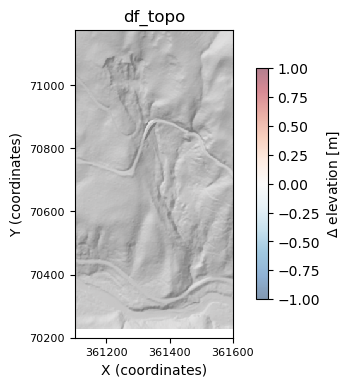

<Figure size 1200x1200 with 0 Axes>

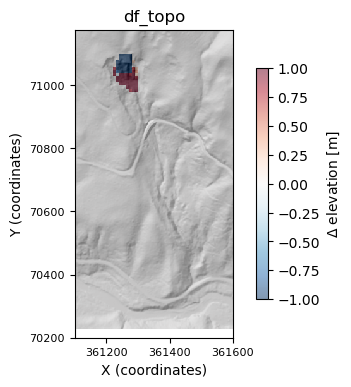

<Figure size 1200x1200 with 0 Axes>

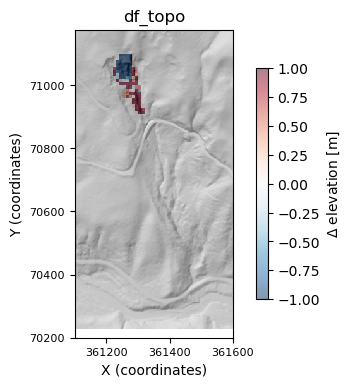

<Figure size 1200x1200 with 0 Axes>

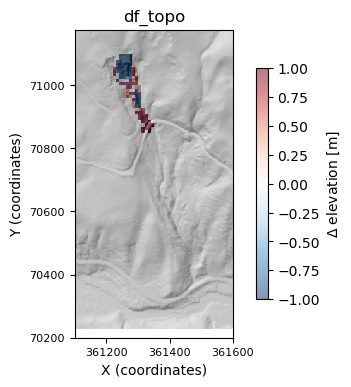

<Figure size 1200x1200 with 0 Axes>

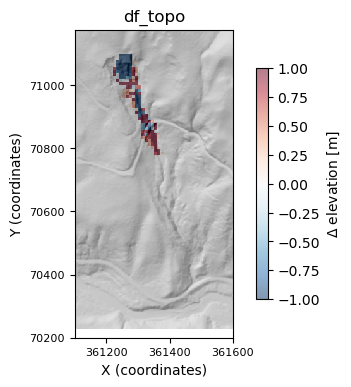

<Figure size 1200x1200 with 0 Axes>

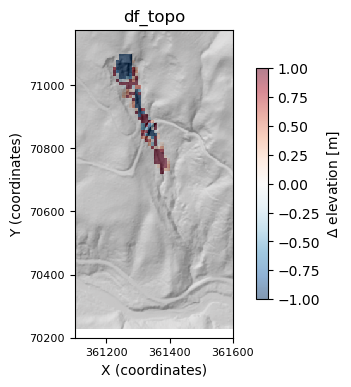

<Figure size 1200x1200 with 0 Axes>

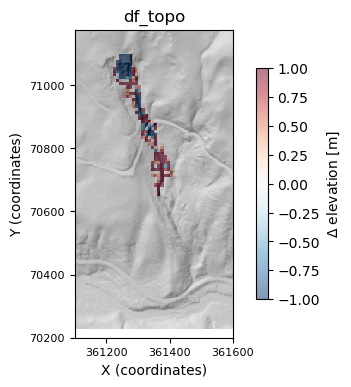

<Figure size 1200x1200 with 0 Axes>

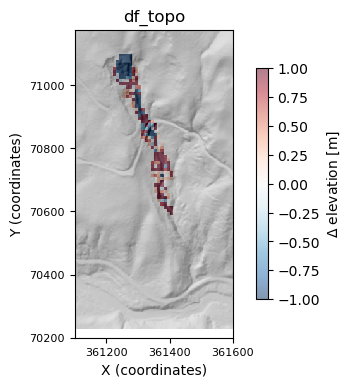

<Figure size 1200x1200 with 0 Axes>

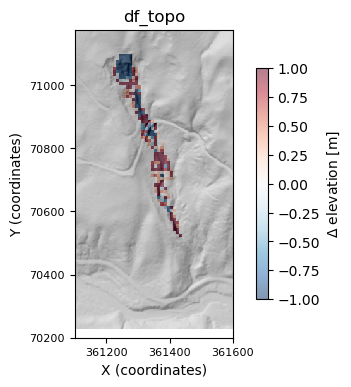

<Figure size 1200x1200 with 0 Axes>

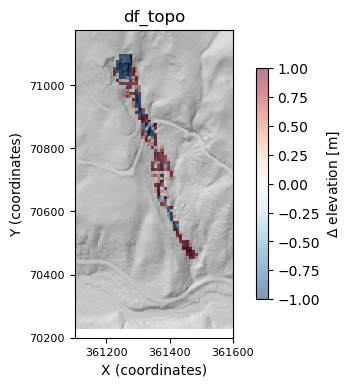

<Figure size 1200x1200 with 0 Axes>

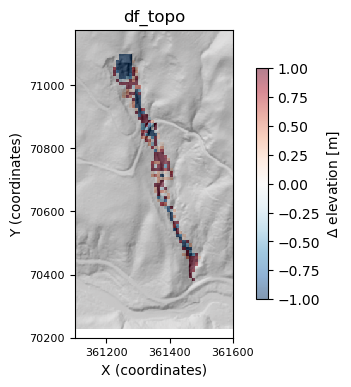

<Figure size 1200x1200 with 0 Axes>

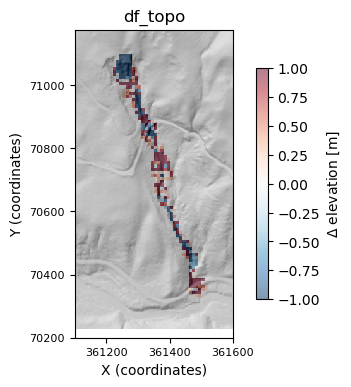

<Figure size 1200x1200 with 0 Axes>

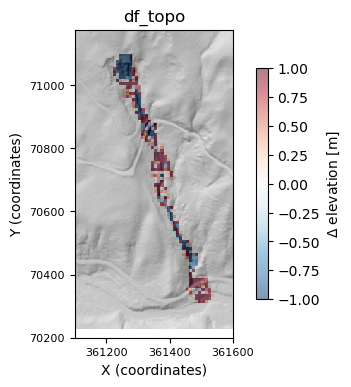

In [8]:
   
# figure domain
mvx = 70200; mvx_ = 71175
mvy = 361100; mvy_ = 361600
imn = 1
for i in np.arange(0,len(MWR.mw_ids)):
    for c in MWR.runout_evo_maps[i].keys():
        if c%7 == 0:        
            plt.figure('dif'+str(c)+str(i),figsize=(12, 12))
            mg.at_node['df_topo'] = MWR.runout_evo_maps[i][c]-mg.at_node['topographic__initial_elevation']
            plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'df_topo',
                                                     plot_name = 'dem dif{},{}'.format(i,c), fontsize = 10,
                                                     cmap = 'RdBu_r',alpha = .5, figsize = (6,4), 
                                                     colorbar_label =r'$\Delta$ elevation [m]' )
            plt.xticks(fontsize= 8 )
            plt.yticks(fontsize= 8 )
            plt.ylim([mvx,mvx_])
            plt.xlim([mvy, mvy_])
            plt.clim(-1,1)

In [11]:
mg.at_node.keys()

['mass__wasting_id',
 'dem_dif_o',
 'soil__thickness',
 'particle__diameter',
 'water__unit_flux_in',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'depression__depth',
 'depression__outlet_node',
 'is_pit',
 'flood_status_code',
 'hillshade',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'flow__receiver_proportions',
 'topographic__steepest_slope',
 'topographic__initial_elevation',
 'energy__elevation',
 'flow__sink_flag',
 'df_topo',
 'topographic__elevation']

<IPython.core.display.Javascript object>


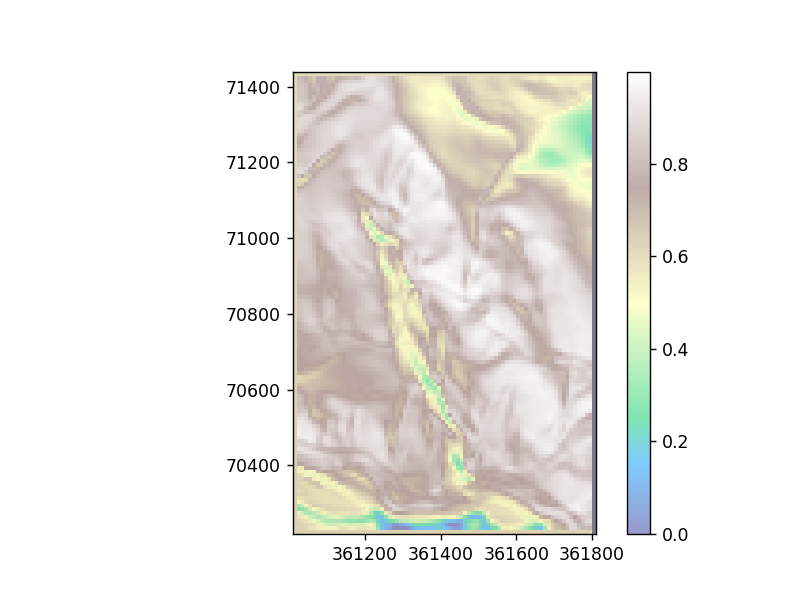

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
%matplotlib notebook

# plotting function
def plot_vals(field = 'topographic__elevation', cmap = "terrain"):
    grid = mg
    def get_values_xy(field):
        values = grid.at_node[field]
        values = values.reshape(grid.shape)
        y = (
            np.arange(values.shape[0] + 1) * grid.dy
            - grid.dy * 0.5
            + grid.xy_of_lower_left[1]
        )
        x = (
            np.arange(values.shape[1] + 1) * grid.dx
            - grid.dx * 0.5
            + grid.xy_of_lower_left[0]
        )
        return x, y, values
    x,y,values = get_values_xy('topographic__elevation') # change to dem_dif_o, see sythetic landscape plotting functions
    myimage = plt.pcolormesh(x, y, values, cmap = cmap, alpha = 1)
    myimage.set_rasterized(True)
    myimage.axes.set_aspect("equal")
    plt.autoscale(tight=True)
    
    x,y,values = get_values_xy('hillshade')
    myimage = plt.pcolormesh(x, y, values, cmap = cmap, alpha = 0.5)
    myimage.set_rasterized(True)
    myimage.axes.set_aspect("equal")
    plt.autoscale(tight=True)    
    
    return myimage

# update function
def update_plot(frame_number, MWR, plot):
    mg.at_node['topographic__elevation'] = MWR.runout_evo_maps[0][frame_number]
    plot[0].remove()
    plot[0] = plot_vals()

# prepare the first frame
fig = plt.figure()
nmax=len(MWR.runout_evo_maps[0].keys())
mg.at_node['topographic__elevation'] = MWR.runout_evo_maps[0][0]
plot = [plot_vals()]
cb = plt.colorbar(norm=True)


animate_1 = animation.FuncAnimation(fig, update_plot, nmax, fargs=(MWR, plot), blit = True, repeat = True)
plt.show()